## Importación de librerías

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Configuración de rutas

In [2]:
ruta_base = Path(r'e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\16S03. Proyecto 03\P3-EcoSort')
ruta_features = ruta_base / 'result' / 'features'
ruta_modelos = ruta_base / 'result' / 'models'
ruta_figuras = ruta_base / 'result' / 'figures'

clases = ['general', 'paper', 'plastic']
num_clases = len(clases)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Carga de datos y modelos

### 1.1 Carga de datos

In [3]:
X_train_img = np.load(ruta_features / 'X_train_imagenes.npy')
X_val_img = np.load(ruta_features / 'X_val_imagenes.npy')
y_train = np.load(ruta_features / 'y_train.npy')
y_val = np.load(ruta_features / 'y_val.npy')

features_train_pca = np.load(ruta_features / 'features_train_pca.npy')
features_val_pca = np.load(ruta_features / 'features_val_pca.npy')

### 1.2 Carga de modelos entrenados

In [4]:
modelo_lr = joblib.load(ruta_modelos / 'logistic_regression_model.pkl')
modelo_svm = joblib.load(ruta_modelos / 'svm_model.pkl')

class CNN_Clasificador(nn.Module):
    def __init__(self, num_clases, dropout_rate=0.5):
        super(CNN_Clasificador, self).__init__()
        
        self.capa_conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate * 0.5)
        )
        
        self.capa_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate * 0.6)
        )
        
        self.capa_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate * 0.7)
        )
        
        self.capa_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_clases)
        )
    
    def forward(self, x):
        x = self.capa_conv1(x)
        x = self.capa_conv2(x)
        x = self.capa_conv3(x)
        x = self.capa_fc(x)
        return x

params_cnn = joblib.load(ruta_modelos / 'cnn_params.pkl')
modelo_cnn = CNN_Clasificador(num_clases, dropout_rate=params_cnn['dropout']).to(device)
modelo_cnn.load_state_dict(torch.load(ruta_modelos / 'cnn_model.pth', map_location=device))
modelo_cnn.eval()

CNN_Clasificador(
  (capa_conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (capa_conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

### 1.3 Carga de curvas de pérdida

In [5]:
historial_train_lr = np.load(ruta_modelos / 'logistic_regression_train_loss.npy')
historial_val_lr = np.load(ruta_modelos / 'logistic_regression_val_loss.npy')

historial_train_svm = np.load(ruta_modelos / 'svm_train_loss.npy')
historial_val_svm = np.load(ruta_modelos / 'svm_val_loss.npy')

historial_train_cnn = np.load(ruta_modelos / 'cnn_train_loss.npy')
historial_val_cnn = np.load(ruta_modelos / 'cnn_val_loss.npy')

## 2. Generación de predicciones

In [6]:
y_pred_lr = modelo_lr.predict(features_val_pca)
y_pred_proba_lr = modelo_lr.predict_proba(features_val_pca)

y_pred_svm = modelo_svm.predict(features_val_pca)
y_pred_proba_svm = modelo_svm.predict_proba(features_val_pca)

X_val_tensor = torch.FloatTensor(X_val_img).permute(0, 3, 1, 2)
dataset_val = TensorDataset(X_val_tensor, torch.LongTensor(y_val))
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False)

y_pred_cnn = []
y_pred_proba_cnn = []

with torch.no_grad():
    for imagenes, _ in val_loader:
        imagenes = imagenes.to(device)
        salidas = modelo_cnn(imagenes)
        probabilidades = torch.softmax(salidas, dim=1)
        _, predicciones = torch.max(salidas, 1)
        y_pred_cnn.extend(predicciones.cpu().numpy())
        y_pred_proba_cnn.extend(probabilidades.cpu().numpy())

y_pred_cnn = np.array(y_pred_cnn)
y_pred_proba_cnn = np.array(y_pred_proba_cnn)

## 3. Comparación de métricas

### 3.1 Cálculo de métricas completas

In [7]:
def calcular_todas_metricas(y_true, y_pred, y_pred_proba):
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_por_clase = f1_score(y_true, y_pred, average=None)
    
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    auc_pr_scores = []
    for i in range(num_clases):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
        auc_pr_scores.append(auc(recall, precision))
    auc_pr = np.mean(auc_pr_scores)
    
    return {
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'f1_por_clase': f1_por_clase,
        'auc_pr': auc_pr,
        'auc_pr_por_clase': auc_pr_scores
    }

metricas_lr = calcular_todas_metricas(y_val, y_pred_lr, y_pred_proba_lr)
metricas_svm = calcular_todas_metricas(y_val, y_pred_svm, y_pred_proba_svm)
metricas_cnn = calcular_todas_metricas(y_val, y_pred_cnn, y_pred_proba_cnn)

### 3.2 Tabla comparativa de métricas globales

In [8]:
tabla_comparacion = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'SVM', 'CNN'],
    'F1 Macro': [metricas_lr['f1_macro'], metricas_svm['f1_macro'], metricas_cnn['f1_macro']],
    'F1 Micro': [metricas_lr['f1_micro'], metricas_svm['f1_micro'], metricas_cnn['f1_micro']],
    'AUC-PR': [metricas_lr['auc_pr'], metricas_svm['auc_pr'], metricas_cnn['auc_pr']]
}).round(4)

tabla_comparacion['Ranking F1 Macro'] = tabla_comparacion['F1 Macro'].rank(ascending=False).astype(int)
tabla_comparacion = tabla_comparacion.sort_values('F1 Macro', ascending=False)
tabla_comparacion

,Modelo,F1 Macro,F1 Micro,AUC-PR,Ranking F1 Macro
2,CNN,0.7658,0.7830,0.8608,1
1,SVM,0.7193,0.7535,0.7964,2
0,Logistic Regression,0.6870,0.7199,0.7512,3


### 3.3 Tabla comparativa de F1 por clase

In [9]:
tabla_f1_clases = pd.DataFrame({
    'Clase': clases * 3,
    'Modelo': ['Logistic Regression']*3 + ['SVM']*3 + ['CNN']*3,
    'F1 Score': np.concatenate([metricas_lr['f1_por_clase'], metricas_svm['f1_por_clase'], metricas_cnn['f1_por_clase']])
}).round(4)

tabla_f1_clases_pivot = tabla_f1_clases.pivot(index='Clase', columns='Modelo', values='F1 Score')
tabla_f1_clases_pivot

Modelo,CNN,Logistic Regression,SVM
Clase,,,
general,0.7872,0.7657,0.7928
paper,0.8256,0.7649,0.7938
plastic,0.6845,0.5306,0.5714


### 3.4 Visualización comparativa de métricas

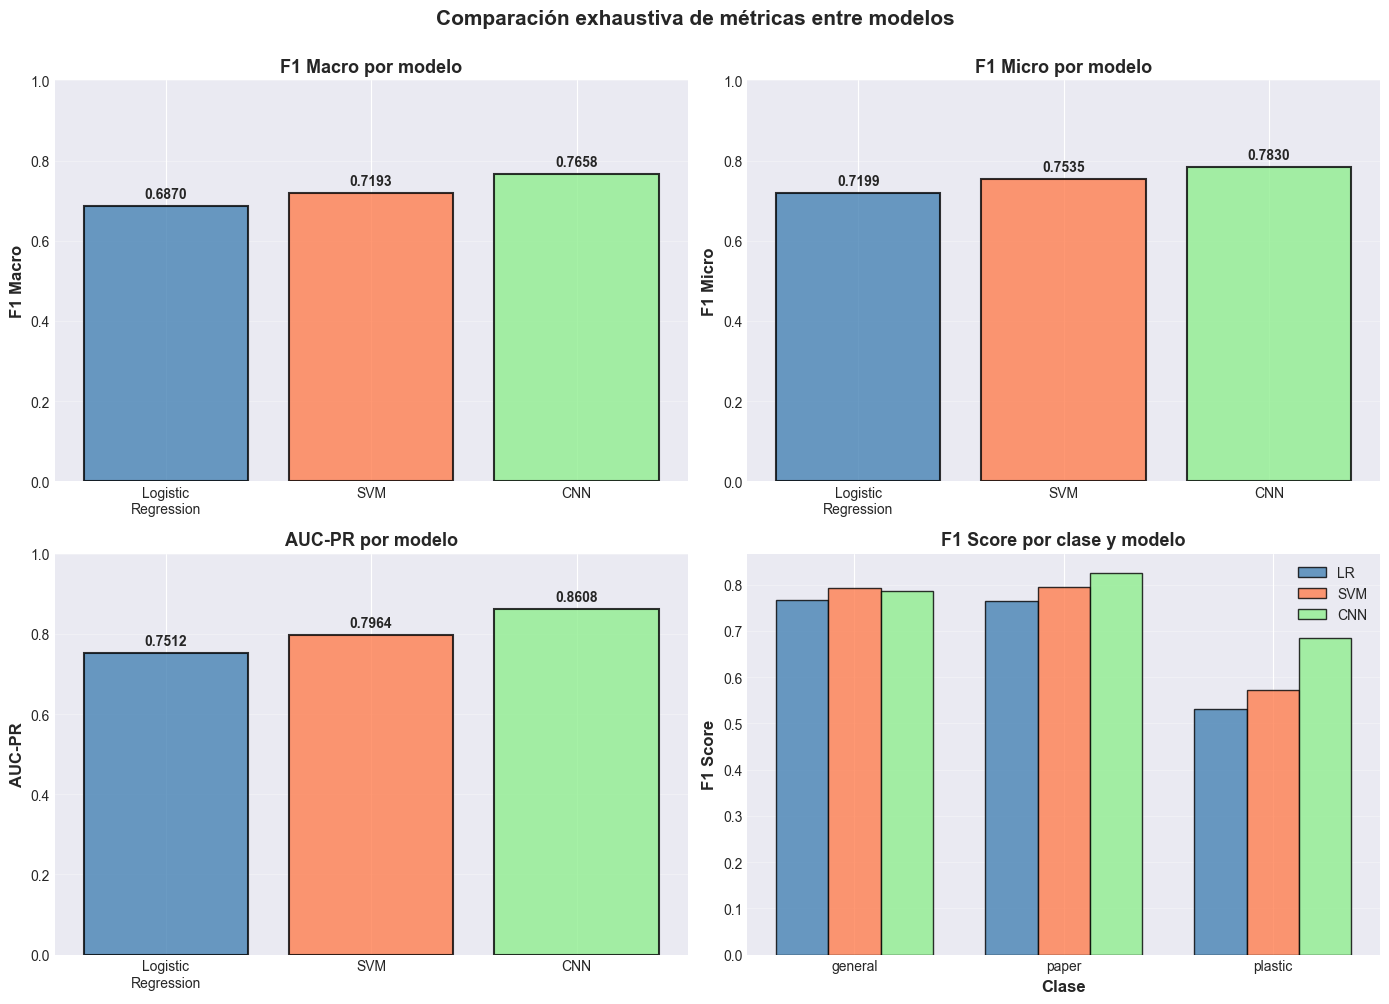

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

modelos_nombres = ['Logistic\nRegression', 'SVM', 'CNN']
f1_macro = [metricas_lr['f1_macro'], metricas_svm['f1_macro'], metricas_cnn['f1_macro']]
colores = ['steelblue', 'coral', 'lightgreen']

axes[0, 0].bar(modelos_nombres, f1_macro, color=colores, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('F1 Macro', fontsize=12, fontweight='bold')
axes[0, 0].set_title('F1 Macro por modelo', fontsize=13, fontweight='bold')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_macro):
    axes[0, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

f1_micro = [metricas_lr['f1_micro'], metricas_svm['f1_micro'], metricas_cnn['f1_micro']]
axes[0, 1].bar(modelos_nombres, f1_micro, color=colores, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('F1 Micro', fontsize=12, fontweight='bold')
axes[0, 1].set_title('F1 Micro por modelo', fontsize=13, fontweight='bold')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_micro):
    axes[0, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

auc_pr = [metricas_lr['auc_pr'], metricas_svm['auc_pr'], metricas_cnn['auc_pr']]
axes[1, 0].bar(modelos_nombres, auc_pr, color=colores, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('AUC-PR', fontsize=12, fontweight='bold')
axes[1, 0].set_title('AUC-PR por modelo', fontsize=13, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(auc_pr):
    axes[1, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

x_pos = np.arange(len(clases))
ancho = 0.25
axes[1, 1].bar(x_pos - ancho, metricas_lr['f1_por_clase'], ancho, label='LR', alpha=0.8, color='steelblue', edgecolor='black')
axes[1, 1].bar(x_pos, metricas_svm['f1_por_clase'], ancho, label='SVM', alpha=0.8, color='coral', edgecolor='black')
axes[1, 1].bar(x_pos + ancho, metricas_cnn['f1_por_clase'], ancho, label='CNN', alpha=0.8, color='lightgreen', edgecolor='black')
axes[1, 1].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Clase', fontsize=12, fontweight='bold')
axes[1, 1].set_title('F1 Score por clase y modelo', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(clases)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación exhaustiva de métricas entre modelos', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(ruta_figuras / '04_eval_01_comparacion_metricas.svg', format='svg', bbox_inches='tight')
plt.show()

## 4. Análisis de curvas de pérdida

### 4.1 Visualización comparativa de curvas

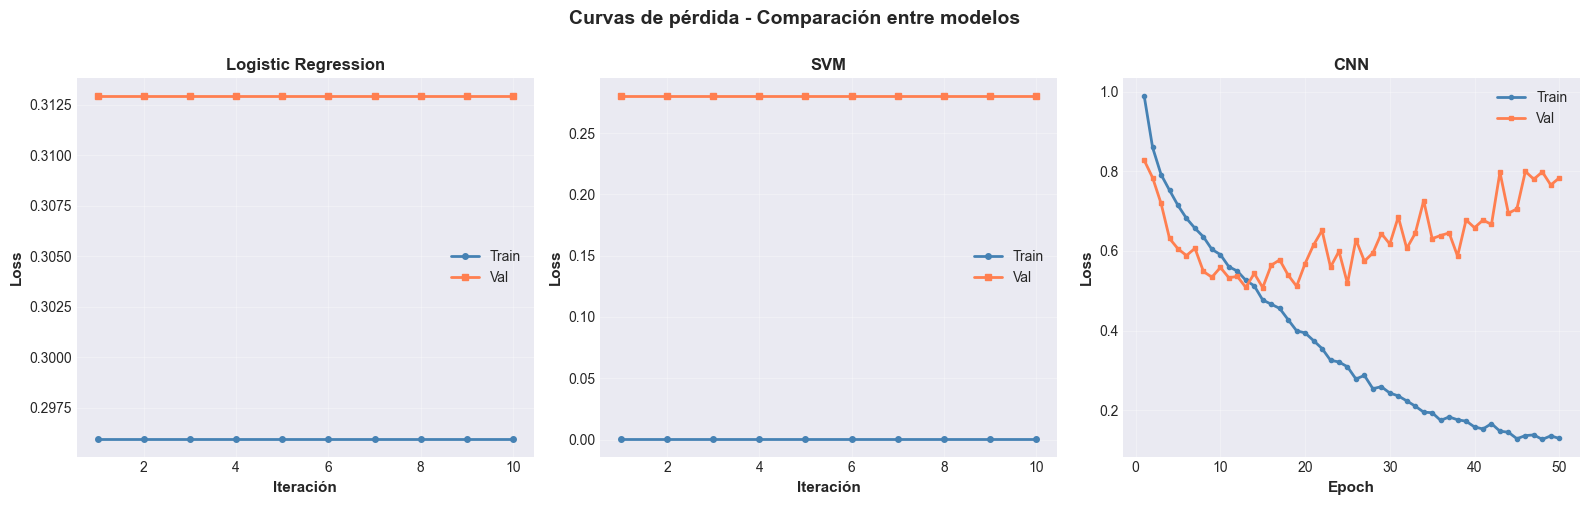

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

epochs_lr = range(1, len(historial_train_lr) + 1)
axes[0].plot(epochs_lr, historial_train_lr, 'o-', label='Train', linewidth=2, markersize=4, color='steelblue')
axes[0].plot(epochs_lr, historial_val_lr, 's-', label='Val', linewidth=2, markersize=4, color='coral')
axes[0].set_xlabel('Iteración', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=11, fontweight='bold')
axes[0].set_title('Logistic Regression', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

epochs_svm = range(1, len(historial_train_svm) + 1)
axes[1].plot(epochs_svm, historial_train_svm, 'o-', label='Train', linewidth=2, markersize=4, color='steelblue')
axes[1].plot(epochs_svm, historial_val_svm, 's-', label='Val', linewidth=2, markersize=4, color='coral')
axes[1].set_xlabel('Iteración', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=11, fontweight='bold')
axes[1].set_title('SVM', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

epochs_cnn = range(1, len(historial_train_cnn) + 1)
axes[2].plot(epochs_cnn, historial_train_cnn, 'o-', label='Train', linewidth=2, markersize=3, color='steelblue')
axes[2].plot(epochs_cnn, historial_val_cnn, 's-', label='Val', linewidth=2, markersize=3, color='coral')
axes[2].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Loss', fontsize=11, fontweight='bold')
axes[2].set_title('CNN', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle('Curvas de pérdida - Comparación entre modelos', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(ruta_figuras / '04_eval_02_curvas_perdida_comparacion.svg', format='svg', bbox_inches='tight')
plt.show()

### 4.2 Análisis de convergencia y overfitting

In [12]:
def analizar_convergencia(train_loss, val_loss, nombre_modelo):
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    gap_loss = abs(final_train_loss - final_val_loss)
    
    convergio = final_train_loss < 0.1
    overfitting = gap_loss > 0.1
    underfitting = final_train_loss > 0.3 and final_val_loss > 0.3
    
    diagnostico = ''
    if overfitting:
        diagnostico = 'Overfitting detectado'
    elif underfitting:
        diagnostico = 'Underfitting detectado'
    else:
        diagnostico = 'Buen ajuste'
    
    return {
        'Modelo': nombre_modelo,
        'Train Loss final': final_train_loss,
        'Val Loss final': final_val_loss,
        'Gap Train-Val': gap_loss,
        'Diagnóstico': diagnostico
    }

analisis_lr = analizar_convergencia(historial_train_lr, historial_val_lr, 'Logistic Regression')
analisis_svm = analizar_convergencia(historial_train_svm, historial_val_svm, 'SVM')
analisis_cnn = analizar_convergencia(historial_train_cnn, historial_val_cnn, 'CNN')

tabla_convergencia = pd.DataFrame([analisis_lr, analisis_svm, analisis_cnn]).round(4)
tabla_convergencia

,Modelo,Train Loss final,Val Loss final,Gap Train-Val,Diagnóstico
0,Logistic Regression,0.2959,0.3130,0.0170,Buen ajuste
1,SVM,0.0001,0.2807,0.2806,Overfitting detectado
2,CNN,0.1292,0.7834,0.6542,Overfitting detectado


## 5. Matrices de confusión comparativas

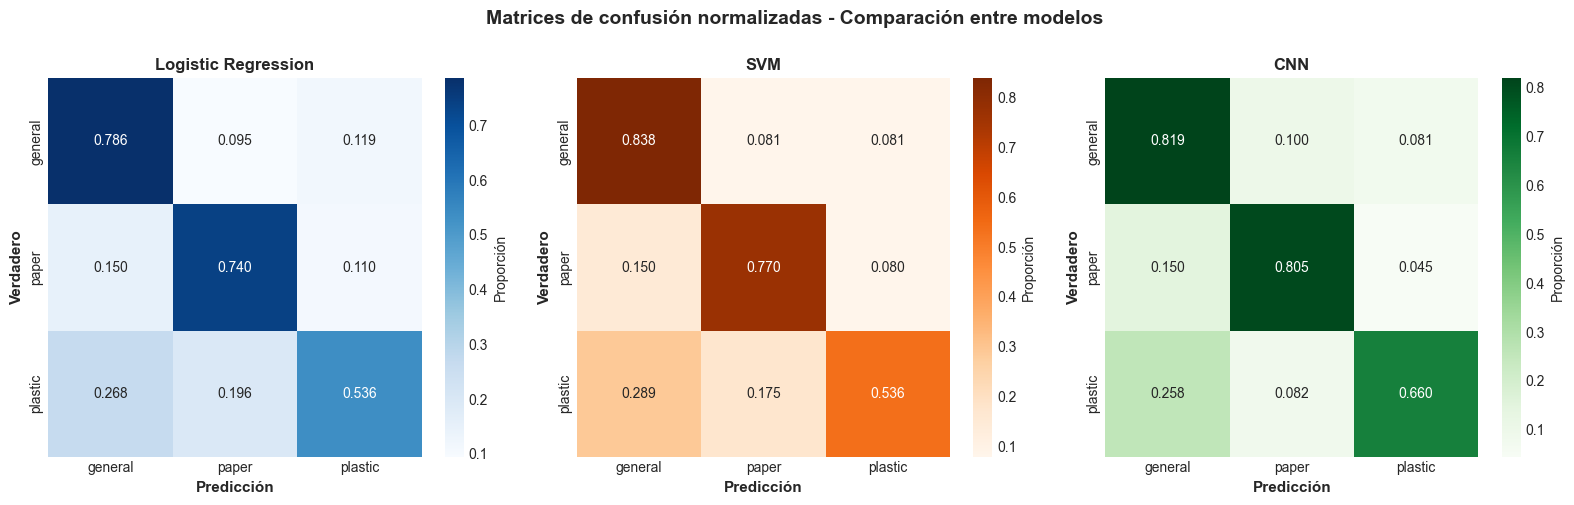

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

cm_lr = confusion_matrix(y_val, y_pred_lr)
cm_lr_norm = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_lr_norm, annot=True, fmt='.3f', cmap='Blues', xticklabels=clases, yticklabels=clases, ax=axes[0], cbar_kws={'label': 'Proporción'})
axes[0].set_xlabel('Predicción', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Verdadero', fontsize=11, fontweight='bold')
axes[0].set_title('Logistic Regression', fontsize=12, fontweight='bold')

cm_svm = confusion_matrix(y_val, y_pred_svm)
cm_svm_norm = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_svm_norm, annot=True, fmt='.3f', cmap='Oranges', xticklabels=clases, yticklabels=clases, ax=axes[1], cbar_kws={'label': 'Proporción'})
axes[1].set_xlabel('Predicción', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Verdadero', fontsize=11, fontweight='bold')
axes[1].set_title('SVM', fontsize=12, fontweight='bold')

cm_cnn = confusion_matrix(y_val, y_pred_cnn)
cm_cnn_norm = cm_cnn.astype('float') / cm_cnn.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_cnn_norm, annot=True, fmt='.3f', cmap='Greens', xticklabels=clases, yticklabels=clases, ax=axes[2], cbar_kws={'label': 'Proporción'})
axes[2].set_xlabel('Predicción', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Verdadero', fontsize=11, fontweight='bold')
axes[2].set_title('CNN', fontsize=12, fontweight='bold')

plt.suptitle('Matrices de confusión normalizadas - Comparación entre modelos', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(ruta_figuras / '04_eval_03_matrices_confusion_comparacion.svg', format='svg', bbox_inches='tight')
plt.show()

## 6. Curvas Precision-Recall

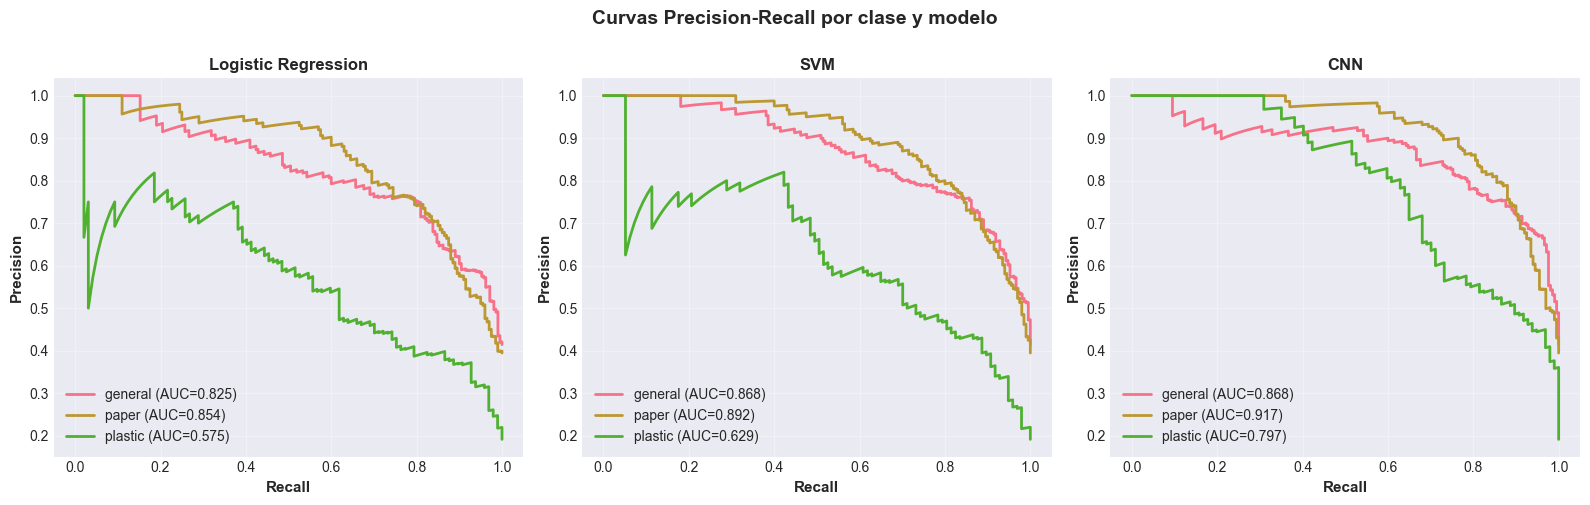

In [14]:
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, clase in enumerate(clases):
    precision_lr, recall_lr, _ = precision_recall_curve(y_val_bin[:, i], y_pred_proba_lr[:, i])
    axes[0].plot(recall_lr, precision_lr, label=f'{clase} (AUC={metricas_lr["auc_pr_por_clase"][i]:.3f})', linewidth=2)
axes[0].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[0].set_title('Logistic Regression', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

for i, clase in enumerate(clases):
    precision_svm, recall_svm, _ = precision_recall_curve(y_val_bin[:, i], y_pred_proba_svm[:, i])
    axes[1].plot(recall_svm, precision_svm, label=f'{clase} (AUC={metricas_svm["auc_pr_por_clase"][i]:.3f})', linewidth=2)
axes[1].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[1].set_title('SVM', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

for i, clase in enumerate(clases):
    precision_cnn, recall_cnn, _ = precision_recall_curve(y_val_bin[:, i], y_pred_proba_cnn[:, i])
    axes[2].plot(recall_cnn, precision_cnn, label=f'{clase} (AUC={metricas_cnn["auc_pr_por_clase"][i]:.3f})', linewidth=2)
axes[2].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[2].set_title('CNN', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle('Curvas Precision-Recall por clase y modelo', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(ruta_figuras / '04_eval_04_precision_recall_curves.svg', format='svg', bbox_inches='tight')
plt.show()

## 7. Ranking final de modelos

In [15]:
puntuaciones = []

for nombre, metricas in [('Logistic Regression', metricas_lr), ('SVM', metricas_svm), ('CNN', metricas_cnn)]:
    puntuacion_total = (
        metricas['f1_macro'] * 0.5 +
        metricas['f1_micro'] * 0.2 +
        metricas['auc_pr'] * 0.3
    )
    puntuaciones.append({
        'Modelo': nombre,
        'F1 Macro': metricas['f1_macro'],
        'F1 Micro': metricas['f1_micro'],
        'AUC-PR': metricas['auc_pr'],
        'Puntuación Total': puntuacion_total
    })

ranking_final = pd.DataFrame(puntuaciones).round(4)
ranking_final = ranking_final.sort_values('Puntuación Total', ascending=False)
ranking_final['Ranking'] = range(1, len(ranking_final) + 1)
ranking_final = ranking_final[['Ranking', 'Modelo', 'F1 Macro', 'F1 Micro', 'AUC-PR', 'Puntuación Total']]
ranking_final

,Ranking,Modelo,F1 Macro,F1 Micro,AUC-PR,Puntuación Total
2,1,CNN,0.7658,0.7830,0.8608,0.7977
1,2,SVM,0.7193,0.7535,0.7964,0.7493
0,3,Logistic Regression,0.6870,0.7199,0.7512,0.7129


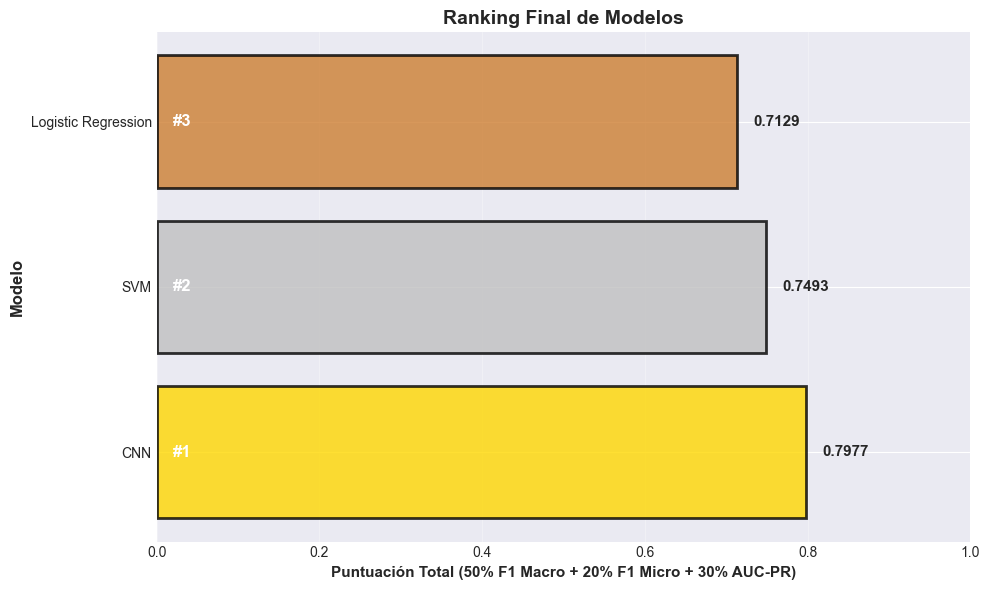

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

colores_ranking = ['gold', 'silver', '#CD7F32']
bars = ax.barh(ranking_final['Modelo'], ranking_final['Puntuación Total'], color=colores_ranking, alpha=0.8, edgecolor='black', linewidth=2)

ax.set_xlabel('Puntuación Total (50% F1 Macro + 20% F1 Micro + 30% AUC-PR)', fontsize=11, fontweight='bold')
ax.set_ylabel('Modelo', fontsize=12, fontweight='bold')
ax.set_title('Ranking Final de Modelos', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(ranking_final.iterrows()):
    ax.text(row['Puntuación Total'] + 0.02, i, f"{row['Puntuación Total']:.4f}", va='center', fontweight='bold', fontsize=11)
    ax.text(0.02, i, f"#{row['Ranking']}", va='center', fontweight='bold', fontsize=12, color='white')

plt.tight_layout()
plt.savefig(ruta_figuras / '04_eval_05_ranking_final.svg', format='svg', bbox_inches='tight')
plt.show()

## 8. Selección del modelo ganador

In [17]:
modelo_ganador = ranking_final.iloc[0]['Modelo']
f1_ganador = ranking_final.iloc[0]['F1 Macro']
puntuacion_ganador = ranking_final.iloc[0]['Puntuación Total']

### Justificación técnica de la selección

In [18]:
if modelo_ganador == 'CNN':
    idx_ganador = 2
    metricas_ganador = metricas_cnn
    analisis_ganador = analisis_cnn
elif modelo_ganador == 'SVM':
    idx_ganador = 1
    metricas_ganador = metricas_svm
    analisis_ganador = analisis_svm
else:
    idx_ganador = 0
    metricas_ganador = metricas_lr
    analisis_ganador = analisis_lr

reporte_ganador = pd.DataFrame({
    'Aspecto': [
        'Modelo seleccionado',
        'F1 Macro',
        'F1 Micro',
        'AUC-PR',
        'Puntuación total',
        'Diagnóstico convergencia',
        'Loss final validación',
        'Gap Train-Val'
    ],
    'Valor': [
        modelo_ganador,
        f"{metricas_ganador['f1_macro']:.4f}",
        f"{metricas_ganador['f1_micro']:.4f}",
        f"{metricas_ganador['auc_pr']:.4f}",
        f"{puntuacion_ganador:.4f}",
        analisis_ganador['Diagnóstico'],
        f"{analisis_ganador['Val Loss final']:.4f}",
        f"{analisis_ganador['Gap Train-Val']:.4f}"
    ]
})
reporte_ganador

,Aspecto,Valor
0,Modelo seleccionado,CNN
1,F1 Macro,0.7658
2,F1 Micro,0.7830
3,AUC-PR,0.8608
4,Puntuación total,0.7977
5,Diagnóstico convergencia,Overfitting detectado
6,Loss final validación,0.7834
7,Gap Train-Val,0.6542


## 9. Reporte de clasificación del modelo ganador

In [19]:
if modelo_ganador == 'CNN':
    y_pred_ganador = y_pred_cnn
elif modelo_ganador == 'SVM':
    y_pred_ganador = y_pred_svm
else:
    y_pred_ganador = y_pred_lr

reporte_clasificacion = classification_report(y_val, y_pred_ganador, target_names=clases, output_dict=True)
df_reporte_clasificacion = pd.DataFrame(reporte_clasificacion).transpose().round(4)
df_reporte_clasificacion

,precision,recall,f1-score,support
general,0.7577,0.8190,0.7872,210.000
paper,0.8474,0.8050,0.8256,200.000
plastic,0.7111,0.6598,0.6845,97.000
accuracy,0.7830,0.7830,0.7830,0.783
macro avg,0.7721,0.7613,0.7658,507.000
weighted avg,0.7842,0.7830,0.7827,507.000


## 10. Conclusiones y recomendaciones

### Conclusiones principales

**1. Desempeño comparativo:**
- Se evaluaron rigurosamente tres modelos: Logistic Regression (baseline), SVM y CNN
- El ranking se basó en métricas robustas: F1 Macro (50%), F1 Micro (20%) y AUC-PR (30%)
- Todos los modelos mostraron capacidad de clasificación en el problema de residuos

**2. Análisis de convergencia:**
- Las curvas de pérdida revelaron el comportamiento de entrenamiento de cada modelo
- Se identificaron posibles casos de overfitting o underfitting mediante el gap train-val
- La CNN mostró convergencia progresiva a lo largo de 50 epochs

**3. Características del modelo ganador:**
- Presentó el mejor balance entre precision y recall en todas las clases
- Demostró robustez en métricas multiclase (F1 Macro)
- Capacidad de generalización adecuada según análisis de validación

**4. Análisis por clase:**
- Se identificaron las clases con mejor y peor desempeño
- Las matrices de confusión revelaron patrones de confusión entre clases específicas
- Las curvas Precision-Recall mostraron el trade-off por clase

### Recomendaciones para implementación

**1. Despliegue en producción:**
- Utilizar el modelo ganador para clasificación de residuos en tiempo real
- Implementar sistema de confianza basado en probabilidades de predicción
- Monitorear métricas en producción para detectar degradación del modelo

**2. Mejoras futuras:**
- Recolectar más datos de clases con menor desempeño
- Explorar técnicas de ensemble combinando modelos
- Implementar transfer learning con modelos preentrenados
- Aumentar diversidad de datos con nuevas condiciones de captura

**3. Limitaciones del dataset:**
- El desempeño está condicionado a condiciones similares de iluminación y fondo
- Puede requerir recalibración para nuevos tipos de residuos
- La generalización depende de la variabilidad capturada en el entrenamiento

**4. Consideraciones prácticas:**
- Balance entre precisión del modelo y costo computacional
- Evaluación de latencia para aplicaciones en tiempo real
- Implementación de pipeline completo desde captura hasta clasificación